In [42]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from gym_minigrid.wrappers import RGBImgPartialObsWrapper
from gym_minigrid.minigrid import Grid, Wall, Goal, Lava
import random

class CustomMiniGridEnv(gym.Env):
    def __init__(self, grid_size=4):
        super(CustomMiniGridEnv, self).__init__()

        self.grid_size = grid_size
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(grid_size * 10, grid_size * 10, 3), dtype=np.uint8)
        self.colors = {
            Wall: [255, 255, 0],   # Wall color (Yellow)
            Lava: [255, 0, 0],     # Lava (Pit) color (Red)
            Goal: [0, 255, 0],     # Goal color (Green)
        }
        
        self.reset()

    def reset(self):
        self.grid = Grid(width=self.grid_size, height=self.grid_size)
        self.player_pos = self.generate_random_position([])
        self.wall_pos = self.generate_random_position([self.player_pos])
        self.goal_pos = self.generate_random_position([self.player_pos, self.wall_pos])
        self.pit_pos = self.generate_random_position([self.player_pos, self.wall_pos, self.goal_pos])

        self.grid.set(*self.wall_pos, Wall())
        self.grid.set(*self.pit_pos, Lava())
        self.grid.set(*self.goal_pos, Goal())

        self.reward_counter = 0
        self.reward = 0
        self.step_counter = 0

        return self.get_observation()

    def step(self, action):
        self.perform_action(action)
        self.step_counter += 1

        done = False
        if self.reward == 10 or self.step_counter > 15 or self.reward == -10:
            done = True

        return self.get_observation(), self.reward, done, {}

    def render(self, mode='human'):
        plt.imshow(self.grid_img)
        plt.axis('off')
        plt.show()

    def generate_random_position(self, existing_positions):
        while True:
            pos = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if pos not in existing_positions:
                return pos

    def perform_action(self, action):
        # Clear the previous player position
        self.grid_img[self.player_pos[0] * 10: (self.player_pos[0] + 1) * 10, self.player_pos[1] * 10: (self.player_pos[1] + 1) * 10] = [0, 0, 0]

        # Update the player position based on the action
        if action == 0:  # Up
            new_pos = (max(self.player_pos[0] - 1, 0), self.player_pos[1])
        elif action == 1:  # Down
            new_pos = (min(self.player_pos[0] + 1, self.grid_size - 1), self.player_pos[1])
        elif action == 2:  # Left
            new_pos = (self.player_pos[0], max(self.player_pos[1] - 1, 0))
        elif action == 3:  # Right
            new_pos = (self.player_pos[0], min(self.player_pos[1] + 1, self.grid_size - 1))

        # Check if the new position is a wall
        if isinstance(self.grid.get(*new_pos), Wall):
            new_pos = self.player_pos  # Stay in the same position if hitting a wall

        # Check if the new position is lava
        if isinstance(self.grid.get(*new_pos), Lava):
            self.reward = -10
        elif isinstance(self.grid.get(*new_pos), Goal):
            self.reward = 10
        else:
            self.reward = -1

        # Update the player position
        self.player_pos = new_pos

        # Highlight the new player position
        self.grid_img[self.player_pos[0] * 10: (self.player_pos[0] + 1) * 10, self.player_pos[1] * 10: (self.player_pos[1] + 1) * 10] = [0, 0, 255]

        # Update the reward counter
        self.reward_counter += self.reward

#         # Print the sum of rewards and the current player position's reward
#         print("Total Reward:", self.reward_counter)
#         print("Current Position's Reward:", self.reward)
#         print("Action Done:", action)

    def get_observation(self):
        self.grid_img = np.zeros((self.grid_size * 10, self.grid_size * 10, 3), dtype=np.uint8)

        # Update the grid image with colors
        for row in range(self.grid_size):
            for col in range(self.grid_size):
                cell_type = self.grid.get(row, col).__class__
                self.grid_img[row * 10: (row + 1) * 10, col * 10: (col + 1) * 10] = self.colors.get(cell_type, [0, 0, 0])

        # Highlight the wall, pit, goal, and player positions
        self.grid_img[self.wall_pos[0] * 10: (self.wall_pos[0] + 1) * 10, self.wall_pos[1] * 10: (self.wall_pos[1] + 1) * 10] = [255, 255, 0]
        self.grid_img[self.pit_pos[0] * 10: (self.pit_pos[0] + 1) * 10, self.pit_pos[1] * 10: (self.pit_pos[1] + 1) * 10] = [255, 0, 0]
        self.grid_img[self.goal_pos[0] * 10: (self.goal_pos[0] + 1) * 10, self.goal_pos[1] * 10: (self.goal_pos[1] + 1) * 10] = [0, 255, 0]
        self.grid_img[self.player_pos[0] * 10: (self.player_pos[0] + 1) * 10, self.player_pos[1] * 10: (self.player_pos[1] + 1) * 10] = [0, 0, 255]

        return self.grid_img
    
    def render_np(self):
        player_slice = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        player_slice[self.player_pos] = 1

        goal_slice = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        goal_slice[self.goal_pos] = 1

        pit_slice = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        pit_slice[self.pit_pos] = 1

        wall_slice = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        wall_slice[self.wall_pos] = 1

        return np.stack([player_slice, goal_slice, pit_slice, wall_slice], axis=0)
    
    def get_positions(self):
        player_pos = self.player_pos[0] * self.grid_size + self.player_pos[1]
        lava_pos = self.pit_pos[0] * self.grid_size + self.pit_pos[1]
        goal_pos = self.goal_pos[0] * self.grid_size + self.goal_pos[1]
        wall_pos = self.wall_pos[0] * self.grid_size + self.wall_pos[1]
        
        return player_pos, lava_pos, goal_pos, wall_pos
    
    def set_positions(self, player_pos, goal_pos, wall_pos, pit_pos):
        # Check if the provided positions are within the grid boundaries
        if not self.is_within_grid(player_pos) or not self.is_within_grid(goal_pos) or not self.is_within_grid(pit_pos) or not self.is_within_grid(wall_pos):
            raise ValueError("Invalid positions provided. Positions must be within the grid boundaries.")

        # Update the grid with the new positions
        self.player_pos = player_pos
        self.goal_pos = goal_pos
        self.pit_pos = pit_pos
        self.wall_pos = wall_pos

        # Clear the previous grid layout
        self.grid = Grid(width=self.grid_size, height=self.grid_size)

        # Set the new positions in the grid
        self.grid.set(*self.player_pos, None)  # Clear any previous entity at the player position
        self.grid.set(*self.goal_pos, Goal())
        self.grid.set(*self.pit_pos, Lava())
        self.grid.set(*self.wall_pos, Wall())

        # Reset other variables
        self.reward_counter = 0
        self.reward = 0
        self.step_counter = 0
        self.get_observation()  # Update the grid image

    def is_within_grid(self, position):
        row, col = position
        return 0 <= row < self.grid_size and 0 <= col < self.grid_size

# Play 10 games

In [ ]:
for game in range(10):
    env = CustomMiniGridEnv(grid_size=4)
    obs = env.reset()

    print("Game", game + 1)
    print("--------")

    done = False
    while not done:
        grid_img = env.get_observation()

        plt.imshow(grid_img)
        plt.axis('off')
        plt.show()
        
        action = env.action_space.sample()  # Random action
        obs, reward, done, _ = env.step(action)

        if done:
            if reward == 10:
                print("Game Result: Win")
            else:
                print("Game Result: Loss")
            break

        print("Step:", env.step_counter)

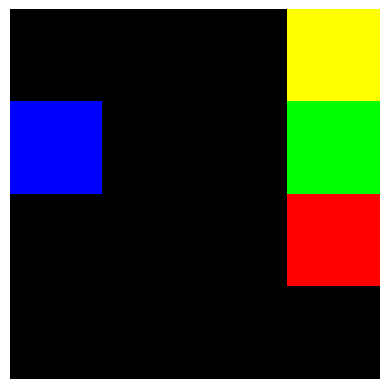

In [8]:
env = CustomMiniGridEnv(grid_size=4)
obs = env.reset()
grid_img = env.get_observation()

plt.imshow(grid_img)
plt.axis('off')
plt.show()

In [9]:
reward

-10

In [11]:
env = CustomMiniGridEnv(grid_size=4)
env.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [27]:
env = CustomMiniGridEnv(grid_size=4)
env.get_positions()

(11, 2, 0, 6)

In [29]:
env.get_positions()[0]

11

In [25]:
env.render_np()

array([[[0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1]],

       [[0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

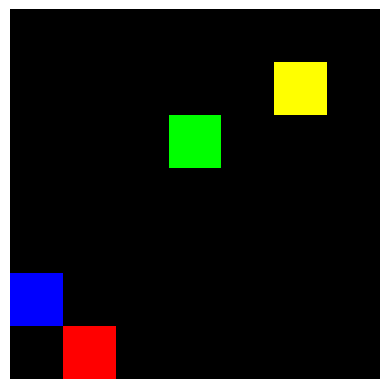

In [12]:
game = CustomMiniGridEnv(grid_size=7)
game.render()

In [35]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 200
l3 = 120
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [36]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D

counter = 0
num = 0
for i in range(epochs):
    game = CustomMiniGridEnv(grid_size=4)
    state1_ = game.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
            
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
                
        
        obs, reward, done, _ = game.step(action_)
        
        state2_ = game.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        next_state = model(state2)
        next_state_ = next_state.data.numpy()
        
        
        if reward == -1 or reward == -10: #N
            Y = reward + (gamma * next_state_[0][np.argmax(next_state_)])
        else:
            Y = reward
            
        done_exp = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done_exp) #G
        replay.append(exp) #H
        state1 = state2
        
        
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i)
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        counter += 1
        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

4999


Text(0, 0.5, 'Loss')

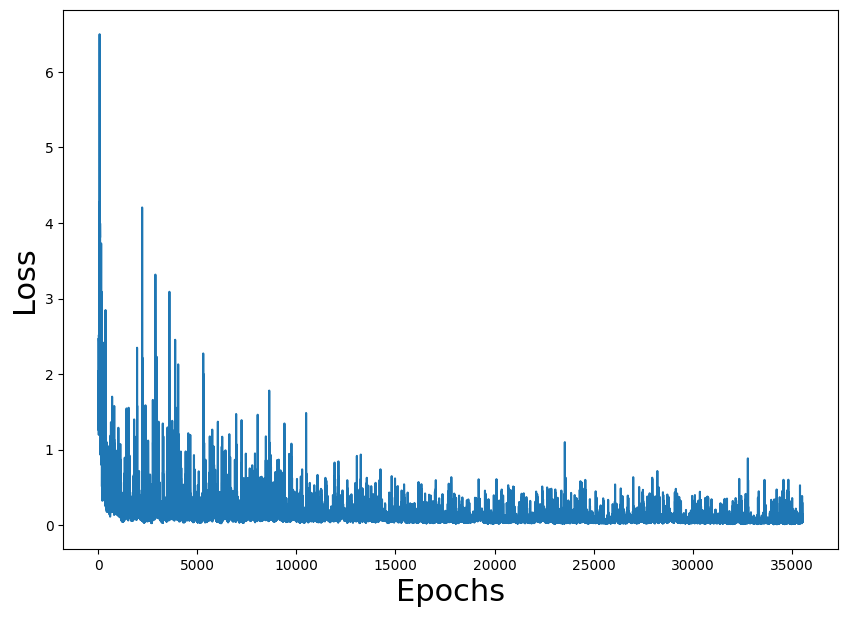

In [37]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [38]:
def dqn_test_model(model, display=True):
    i = 0
    test_game = CustomMiniGridEnv(grid_size=4)
    state_ = test_game.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        test_game.render()
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        
#         p_curr = from2dto1d((str(test_game.board.components['Player'].pos)))
#         pi = from2dto1d((str(test_game.board.components['Pit'].pos)))
#         g = from2dto1d((str(test_game.board.components['Goal'].pos)))
#         w = from2dto1d((str(test_game.board.components['Wall'].pos)))
        
        if display:
            print('Move #: %s; Taking action: %s' % (i, action_))
            
        obs, reward, done, _ = test_game.step(action_)
        
#         p_next = from2dto1d((str(test_game.board.components['Player'].pos)))

        state_ = test_game.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            test_game.render()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

Initial State:


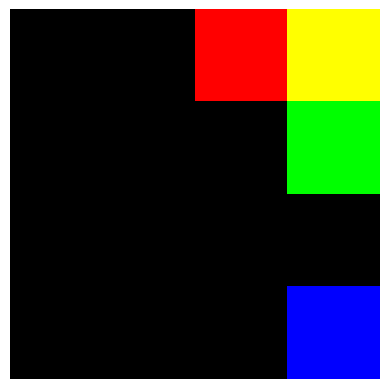

Move #: 0; Taking action: 3


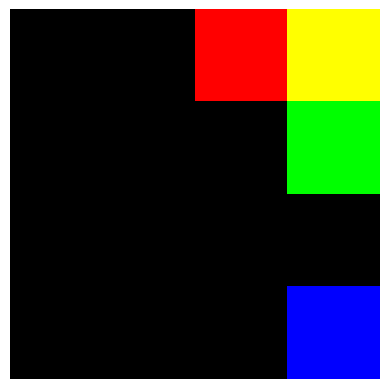

Move #: 1; Taking action: 3


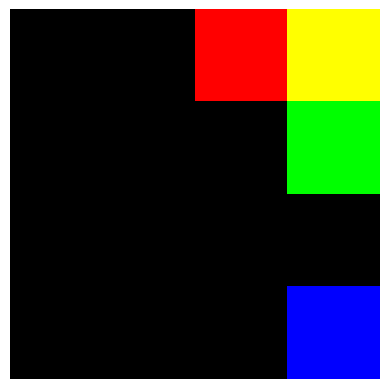

Move #: 2; Taking action: 3


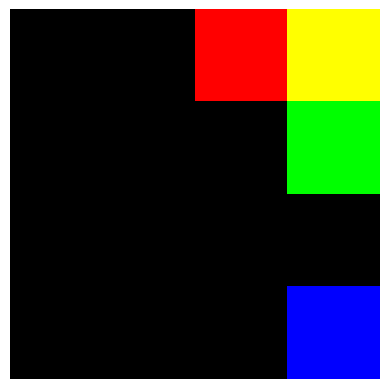

Move #: 3; Taking action: 3


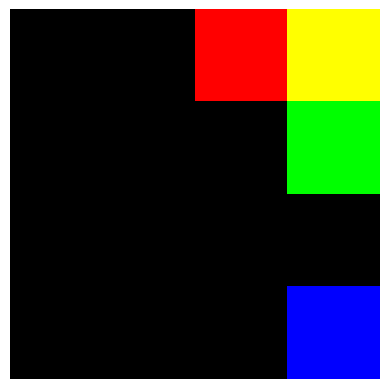

Move #: 4; Taking action: 3


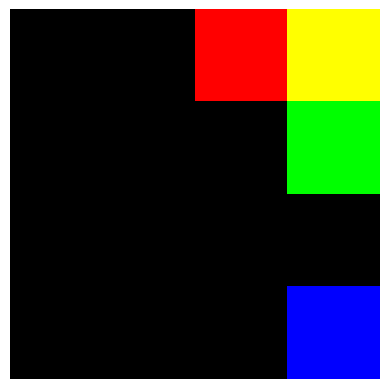

Move #: 5; Taking action: 3


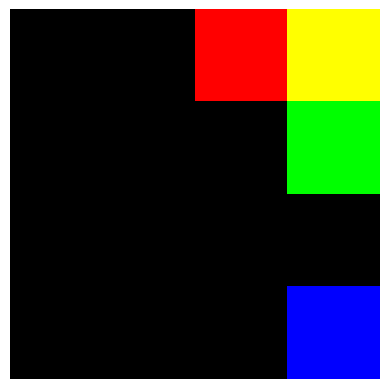

Move #: 6; Taking action: 0


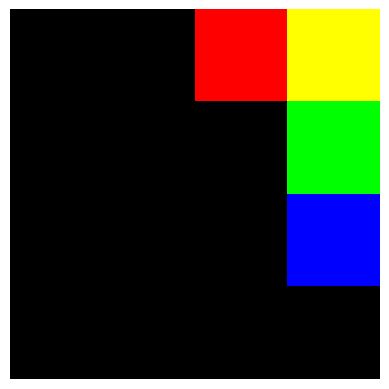

Move #: 7; Taking action: 0


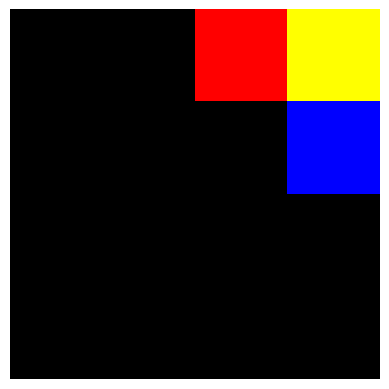

Game won! Reward: 10


True

In [39]:
dqn_test_model(model)

In [40]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = dqn_test_model(model, display = False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num /10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 938
0.938
0.938
Games played: 1000, # of wins: 925
0.925
1.863
Games played: 1000, # of wins: 928
0.928
2.791
Games played: 1000, # of wins: 912
0.912
3.703
Games played: 1000, # of wins: 922
0.922
4.625
Games played: 1000, # of wins: 921
0.921
5.546
Games played: 1000, # of wins: 928
0.928
6.474
Games played: 1000, # of wins: 915
0.915
7.389
Games played: 1000, # of wins: 909
0.909
8.298
Games played: 1000, # of wins: 919
0.919
9.217
Win percentage: 92.17%


## Uniform Dataset Collection from Trained Mode

In [41]:
def from1dto2d(pos):
    if pos == 0:
        return (0, 0)
    if pos == 1:
        return (0, 1)
    if pos == 2:
        return (0, 2)
    if pos == 3:
        return (0, 3)
    if pos == 4:
        return (1, 0)
    if pos == 5:
        return (1, 1)
    if pos == 6:
        return (1, 2)
    if pos == 7:
        return (1, 3)
    if pos == 8:
        return (2, 0)
    if pos == 9:
        return (2, 1)
    if pos == 10:
        return (2, 2)
    if pos == 11:
        return (2, 3)
    if pos == 12:
        return (3, 0)
    if pos == 13:
        return (3, 1)
    if pos == 14:
        return (3, 2)
    if pos == 15:
        return (3, 3)

In [48]:
h = 0
w, h = 9, 100000
matrix = [[0 for x in range(w)] for y in range(h)] 

counter = 0
num = 0
epoch = 0
epsilon = 0
for i in range(0,16):
    for j in range(0,16):
        for k in range (0,16):
            for c in range (0,16):
                if  c != j and k != i and k!= j and i != j:
                    game = CustomMiniGridEnv(grid_size=4)
                    player_pos = from1dto2d(c)
                    goal_pos = from1dto2d(k)
                    wall_pos = from1dto2d(j)
                    pit_pos = from1dto2d(i)
                    
                    game.set_positions(player_pos, goal_pos, wall_pos, pit_pos)
                    
                    state1_ = game.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
                    state1 = torch.from_numpy(state1_).float()
                    status = 1
                    qval = model(state1) #E
                    qval_ = qval.data.numpy()
                    
                   
                    matrix[counter][0] = game.get_positions()[0]
                    matrix[counter][1] = game.get_positions()[1]
                    matrix[counter][2] = game.get_positions()[2]
                    matrix[counter][3] = game.get_positions()[3]

                    matrix[counter][5] = qval_[0][0]
                    matrix[counter][6] = qval_[0][1]
                    matrix[counter][7] = qval_[0][2]
                    matrix[counter][8] = qval_[0][3]

                    if (random.random() < epsilon): #F
                        action_ = np.random.randint(0,4)
                    else:
                        action_ = np.argmax(qval_)                    
                    
                    obs, reward, done, _ = game.step(action_)
                    
                    matrix[counter][4] = reward
                    
                    state2_ = game.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
                    state2 = torch.from_numpy(state2_).float()
                    next_state = model(state2)
                    next_state_ = next_state.data.numpy()
                    
                    done = True if reward > 0 else False
                    state1 = state2
                    print(epoch)
                    clear_output(wait=True)
                    counter += 1
                    epoch += 1

50399


In [49]:
import pandas as pd
column_names = ["Current_State", "Pit_Position", "Goal_Position", "Wall_Position",  "Current_Reward", 
                 "Q1_UP", "Q2_DOWN", "Q3_LEFT", "Q4_RIGHT"
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]
df

,Current_State,Pit_Position,Goal_Position,Wall_Position,Current_Reward,Q1_UP,Q2_DOWN,Q3_LEFT,Q4_RIGHT
0,0,0,2,1,-10,4.946462,4.695930,4.974383,4.760919
1,2,0,2,1,-1,8.128312,8.142357,7.115776,7.350907
2,3,0,2,1,10,6.755848,5.773548,9.332119,7.258504
3,4,0,2,1,-1,3.076944,2.692700,4.710314,6.191459
4,5,0,2,1,-1,6.541164,4.304107,5.105873,8.097490
...,...,...,...,...,...,...,...,...,...
50395,10,15,13,14,-1,5.938396,5.431857,7.606215,4.054748
50396,11,15,13,14,-1,2.553046,2.540612,5.090322,4.031656
50397,12,15,13,14,10,4.916274,4.017373,3.690299,6.726671
50398,13,15,13,14,-1,8.272136,6.379996,4.600275,1.773542


In [50]:
df.to_csv('DatasetBeforeUniform_GYM.csv')

## Non - Uniform Dataset Collection during Training Stage

In [51]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D

h = 0
w, h = 20, 300000
matrix = [[0 for x in range(w)] for y in range(h)] 

counter = 0
num = 0
for i in range(epochs):
    game = CustomMiniGridEnv(grid_size=4)
    state1_ = game.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        
        matrix[counter][0] = i + 5000
        matrix[counter][1] = game.get_positions()[0]
        matrix[counter][2] = game.get_positions()[1]
        matrix[counter][3] = game.get_positions()[2]
        matrix[counter][4] = game.get_positions()[3]
        
                        
        matrix[counter][9] = qval_[0][np.argmax(qval_)]
        matrix[counter][10] = qval_[0][0]
        matrix[counter][11] = qval_[0][1]
        matrix[counter][12] = qval_[0][2]
        matrix[counter][13] = qval_[0][3]
                        
            
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
            matrix[counter][8] = 1 
        else:
            action_ = np.argmax(qval_)
            matrix[counter][8] = 0 
        
        matrix[counter][5] = action_
        
        obs, reward, done, _ = game.step(action_)
        
        state2_ = game.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        next_state = model(state2)
        next_state_ = next_state.data.numpy()
        
        matrix[counter][18] = next_state_[0][np.argmax(next_state_)]
        matrix[counter][14] = next_state_[0][0]
        matrix[counter][15] = next_state_[0][1]
        matrix[counter][16] = next_state_[0][2]
        matrix[counter][17] = next_state_[0][3]
        matrix[counter][6] = reward
        
        if reward == -1 or reward == -10: #N
            Y = reward + (gamma * next_state_[0][np.argmax(next_state_)])
        else:
            Y = reward
        matrix[counter][19] = Y  
        done = True if reward > 0 else False
        matrix[counter][7] = game.get_positions()[0]
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i)
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        counter += 1
        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

4999


In [52]:
import pandas as pd
column_names = ["Epochs","Player", "Pit", "Goal", "Wall", "Action",  "Reward", "Next_State", "Epsilon_Boolean", 
                "Q_MAX",  "Q1_UP", "Q2_DOWN", "Q3_LEFT", "Q4_RIGHT",  "Q1_UP_NEXT", "Q2_DOWN_NEXT", "Q3_LEFT_NEXT", "Q4_RIGHT_NEXT","Q_MAX_NEXT", "Y"
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]
df

,Epochs,Player,Pit,Goal,Wall,Action,Reward,Next_State,Epsilon_Boolean,Q_MAX,Q1_UP,Q2_DOWN,Q3_LEFT,Q4_RIGHT,Q1_UP_NEXT,Q2_DOWN_NEXT,Q3_LEFT_NEXT,Q4_RIGHT_NEXT,Q_MAX_NEXT,Y
0,5000,7,14,4,13,2,-1,6,0,6.062968,3.479241,5.422428,6.062968,3.602073,4.272051,6.197496,7.599072,4.462092,7.599072,5.839165
1,5000,6,14,4,13,2,-1,5,0,7.599072,4.272051,6.197496,7.599072,4.462092,6.417338,7.986413,11.033390,5.889728,11.033390,8.930051
2,5000,5,14,4,13,2,10,4,0,11.033390,6.417338,7.986413,11.033390,5.889728,6.913105,6.788280,7.669920,5.922499,7.669920,10.000000
3,5001,15,10,6,2,0,-1,11,0,5.646697,5.646697,4.463362,2.770998,4.443552,7.753917,5.452022,3.113808,5.731588,7.753917,5.978525
4,5001,11,10,6,2,0,-1,7,0,7.753917,7.753917,5.452022,3.113808,5.731588,7.503795,3.967476,8.873061,7.824474,8.873061,6.985755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18576,9998,10,13,5,11,0,-1,6,0,8.031532,8.031532,3.936372,6.951592,3.961432,8.356394,7.289367,10.148597,6.493959,10.148597,8.133737
18577,9998,6,13,5,11,2,10,5,0,10.162380,8.402393,7.285714,10.162380,6.481378,9.240396,8.338165,7.988938,8.698484,9.240396,10.000000
18578,9999,15,7,12,1,2,-1,14,0,6.003728,3.690572,4.656336,6.003728,4.239810,6.086253,5.985104,7.620012,6.476632,7.620012,5.858011
18579,9999,14,7,12,1,2,-1,13,0,7.623302,6.092485,5.976284,7.623302,6.468684,8.303739,8.453712,9.373241,7.784957,9.373241,7.435917


In [53]:
df.to_csv('DatasetBeforeNonUniform_GYM.csv')